## homework3-3 
Data description of your data and whether data has outliers

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


plt.rcParams['font.sans-serif'] = ['SimHei']  #黑体
plt.rcParams['axes.unicode_minus'] = False  

import warnings
warnings.filterwarnings('ignore')

数据加载与合并

In [4]:
# 加载文件
df_esf_Zhongxin = pd.read_excel("Tianjin_Zhongxin_esf_data.xlsx")
df_esf_Zhongxin['location'] = '中新' 
df_zu_Zhongxin = pd.read_excel("Tianjin_Zhongxin_zu_data.xlsx")
df_zu_Zhongxin['location'] = '中新'

df_esf_Wuqing = pd.read_excel("Tianjin_Wuqing_esf_data.xlsx")
df_esf_Wuqing['location'] = '武清'
df_zu_Wuqing = pd.read_excel("Tianjin_Wuqing_zu_data.xlsx")
df_zu_Wuqing['location'] = '武清'

df_esf_Quanyechang = pd.read_excel("Tianjin_Quanyechang_esf_data.xlsx")
df_esf_Quanyechang['location'] = '劝业场' 
df_zu_Quanyechang = pd.read_excel("Tianjin_Quanyechang_zu_data.xlsx")
df_zu_Quanyechang['location'] = '劝业场'

df_esf_Balitai = pd.read_excel("Tianjin_Balitai_esf_data.xlsx")
df_esf_Balitai['location'] = '八里台' 
df_zu_Balitai = pd.read_excel("Tianjin_Balitai_zu_data.xlsx")
df_zu_Balitai['location'] = '八里台'


# 合并所有租房数据
df_zu_all = pd.concat([df_zu_Balitai, df_zu_Quanyechang, df_zu_Wuqing, df_zu_Zhongxin], ignore_index=True)
df_esf_all = pd.concat([df_esf_Balitai, df_esf_Quanyechang, df_esf_Wuqing, df_esf_Zhongxin], ignore_index=True)

In [5]:
# 统一列名
df_esf_all.rename(columns={
    '面积(㎡)': 'area',
    '单价(元/㎡)': 'price_per_m2' , 
    '总价(万)':'total_price'
}, inplace=True)

df_zu_all.rename(columns={
    '面积(㎡)': 'area',
    '租金(元/月)': 'rent_monthly'
}, inplace=True)

# 计算租金单价
df_zu_all['rent_per_m2'] = df_zu_all['rent_monthly'] / df_zu_all['area']

# 验证结果
print("处理后的二手房数据前5行:")
print(df_esf_all.head())
print("\n处理后的租房数据前5行:")
print(df_zu_all.head())

处理后的二手房数据前5行:
   area  total_price  price_per_m2 location
0  67.0        436.0         21727      八里台
1  66.0        406.0         39166      八里台
2  67.0        430.0         29518      八里台
3  18.0        410.0         36225      八里台
4  15.0        119.0         20822      八里台

处理后的租房数据前5行:
   area  rent_monthly location  rent_per_m2
0    38          2000      八里台    52.631579
1   400         29000      八里台    72.500000
2    49          1700      八里台    34.693878
3   380         30000      八里台    78.947368
4    71          2200      八里台    30.985915


描述数据与异常值


In [6]:
def describe_data(df, dataset_name):
    print(f"{'='*20}{dataset_name} 描述性统计 {'='*20}")
    numeric_df = df.select_dtypes(include=[np.number])
    # 计算统计量
    desc = numeric_df.describe(percentiles=[.25, .5, .75, .95]).round(2)
    # 变异系数
    cv = (numeric_df.std() / numeric_df.mean()).round(4)
    desc.loc['cv'] = cv
    # 偏度
    skew = numeric_df.skew().round(4)
    desc.loc['skew'] = skew
    print(desc.reset_index().rename(columns={'index': '指标'}))


describe_data(df_esf_all, "二手房数据")
describe_data(df_zu_all, "租房数据")

====================二手房数据 描述性统计 ====================
       指标       area  total_price  price_per_m2
0   count  4800.0000    4800.0000     4800.0000
1    mean    90.1200     250.0900    27129.0200
2     std    56.0100     251.0900    20826.1100
3     min     1.0000      33.0000     3633.0000
4     25%    53.3000     110.0000    11956.7500
5     50%    89.0000     170.0000    20000.0000
6     75%   116.2000     295.0000    37144.2500
7     95%   181.6900     685.2500    70771.0500
8     max   595.1200    2550.0000   170731.0000
9      cv     0.6215       1.0040        0.7677
10   skew     1.6102       3.5413        1.7204
====================租房数据 描述性统计 ====================
       指标       area  rent_monthly  rent_per_m2
0   count  4167.0000     4167.0000    4167.0000
1    mean    89.5500     2989.7500      37.7500
2     std    50.8300     3284.0000      28.3600
3     min     7.0000      300.0000       3.0100
4     25%    58.0000     1550.0000      20.0000
5     50%    88.0000     2300.0

In [7]:
esf = df_esf_all.copy()
zu = df_zu_all.copy()

# 去除面积缺失或 <=0 的记录
esf = esf[esf['area'].notna() & (esf['area'] > 0)].copy()
zu = zu[zu['area'].notna() & (zu['area'] > 0)].copy()

# 如果租金单价缺失，则计算
if 'rent_per_m2' not in zu.columns or zu['rent_per_m2'].isna().any():
    zu['rent_per_m2'] = zu['rent_monthly'] / zu['area']

# 标准化 location 字段为字符串
esf['location'] = esf['location'].astype(str)
zu['location'] = zu['location'].astype(str)

In [8]:
def describe_blockwise(esf_df, zu_df, numeric_cols_esf=['price_per_m2'], numeric_cols_zu=['rent_per_m2']):
    blocks = sorted(set(esf_df['location'].unique()).union(set(zu_df['location'].unique())))
    summary = []
    outlier_info = {}
    for b in blocks:
        row = {'location': b}
        # 二手房部分统计
        df_b_esf = esf_df[esf_df['location'] == b]
        for col in numeric_cols_esf:
            if col in df_b_esf.columns and not df_b_esf[col].dropna().empty:
                s = df_b_esf[col].dropna()
                # IQR 异常值检测
                q1 = s.quantile(0.25)
                q3 = s.quantile(0.75)
                iqr = q3 - q1
                low = q1 - 1.5 * iqr
                high = q3 + 1.5 * iqr
                outliers = df_b_esf[(df_b_esf[col] < low) | (df_b_esf[col] > high)]
                outlier_info[f'{b}_esf_{col}'] = {
                    'n_outliers': len(outliers),
                    'low_threshold': low,
                    'high_threshold': high,
                    'outlier_indices': outliers.index.tolist()
                }
            else:
                row[f'esf_count_{col}'] = 0
        # 租房部分统计
        df_b_zu = zu_df[zu_df['location'] == b]
        for col in numeric_cols_zu:
            if col in df_b_zu.columns and not df_b_zu[col].dropna().empty:
                s = df_b_zu[col].dropna()
                q1 = s.quantile(0.25)
                q3 = s.quantile(0.75)
                iqr = q3 - q1
                low = q1 - 1.5 * iqr
                high = q3 + 1.5 * iqr
                outliers = df_b_zu[(df_b_zu[col] < low) | (df_b_zu[col] > high)]
                outlier_info[f'{b}_zu_{col}'] = {
                    'n_outliers': len(outliers),
                    'low_threshold': low,
                    'high_threshold': high,
                    'outlier_indices': outliers.index.tolist()
                }
            else:
                row[f'zu_count_{col}'] = 0
        summary.append(row)
    summary_df = pd.DataFrame(summary).fillna(0)
    return summary_df, outlier_info

summary_df, outlier_info = describe_blockwise(esf, zu)

print("outlier counts by block & variable:")
for k,v in outlier_info.items():
    print(f"{k}: n_outliers = {v['n_outliers']} (thresholds: {v['low_threshold']:.2f} ~ {v['high_threshold']:.2f})")

outlier counts by block & variable:
中新_esf_price_per_m2: n_outliers = 7 (thresholds: -627.88 ~ 25815.12)
中新_zu_rent_per_m2: n_outliers = 51 (thresholds: 12.20 ~ 37.41)
八里台_esf_price_per_m2: n_outliers = 114 (thresholds: 6751.00 ~ 47879.00)
八里台_zu_rent_per_m2: n_outliers = 28 (thresholds: 8.04 ~ 78.99)
劝业场_esf_price_per_m2: n_outliers = 82 (thresholds: 11341.75 ~ 87683.75)
劝业场_zu_rent_per_m2: n_outliers = 97 (thresholds: 25.34 ~ 102.40)
武清_esf_price_per_m2: n_outliers = 63 (thresholds: 1624.75 ~ 22224.75)
武清_zu_rent_per_m2: n_outliers = 22 (thresholds: -3.95 ~ 35.43)


箱线图

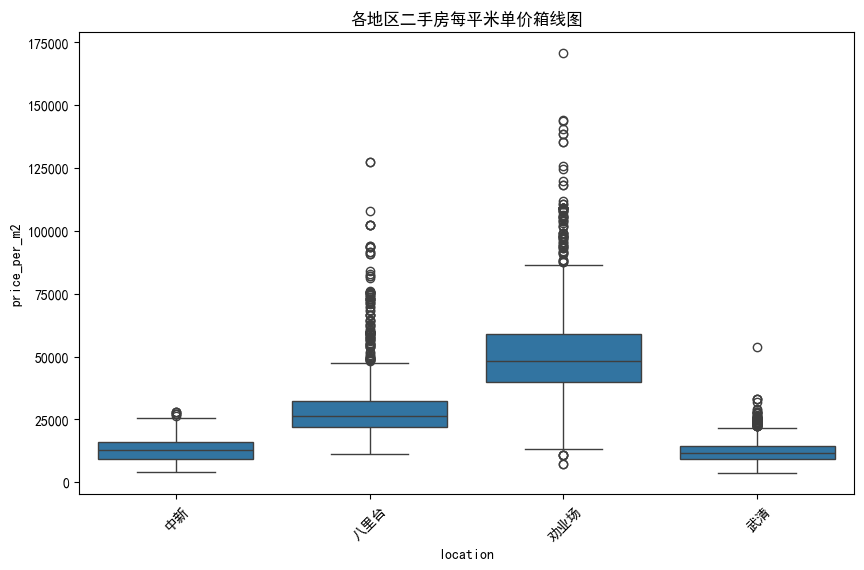

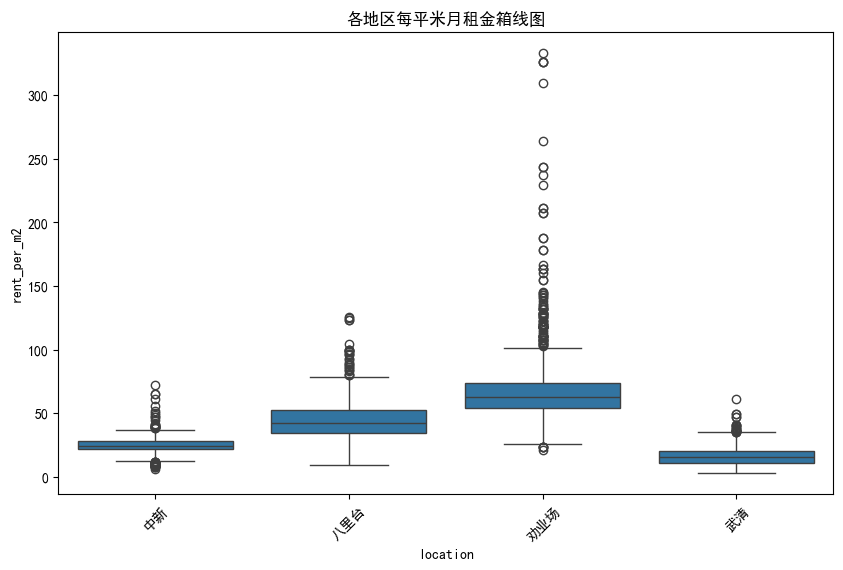

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


all_locations = sorted(set(df_esf_all['location'].unique()).union(set(df_zu_all['location'].unique())))


# 绘制 price_per_m2 的箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(x='location', y='price_per_m2', data=df_esf_all, order=all_locations) 
plt.title('各地区二手房每平米单价箱线图')
plt.xticks(rotation=45) 
plt.show()

# 绘制 rent_per_m2 的箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(x='location', y='rent_per_m2', data=df_zu_all, order=all_locations)
plt.title('各地区每平米月租金箱线图')
plt.xticks(rotation=45) 
plt.show()

删除异常值

In [10]:
print("\n开始删除检测到的异常值...")

# 创建两个集合，分别用于存储二手房和租房数据的异常值索引 使用集合可以自动处理重复的索引
esf_outlier_indices = set()
zu_outlier_indices = set()

# 遍历 outlier_info 字典，将异常值索引添加到对应的集合中
for key, value in outlier_info.items():
    if '_esf_' in key: 
        esf_outlier_indices.update(value['outlier_indices'])
    elif '_zu_' in key: 
        zu_outlier_indices.update(value['outlier_indices'])

esf_original_count = len(esf)
zu_original_count = len(zu)

#  从 DataFrame 中删除异常值
if esf_outlier_indices:
    esf.drop(index=list(esf_outlier_indices), inplace=True)
    
if zu_outlier_indices:
    zu.drop(index=list(zu_outlier_indices), inplace=True)

print(f"操作完成！")
print(f"二手房数据：从 {esf_original_count} 行中删除了 {len(esf_outlier_indices)} 个异常值，剩余 {len(esf)} 行。")
print(f"租房数据：从 {zu_original_count} 行中删除了 {len(zu_outlier_indices)} 个异常值，剩余 {len(zu)} 行。")


print("\n" + "="*20 + "删除异常值后，重新进行描述性统计" + "="*20)
describe_data(esf, "二手房数据 (已清洗)")
describe_data(zu, "租房数据 (已清洗)")


开始删除检测到的异常值...
操作完成！
二手房数据：从 4800 行中删除了 266 个异常值，剩余 4534 行。
租房数据：从 4167 行中删除了 198 个异常值，剩余 3969 行。

====================删除异常值后，重新进行描述性统计====================
====================二手房数据 (已清洗) 描述性统计 ====================
       指标       area  total_price  price_per_m2
0   count  4534.0000     4534.000     4534.0000
1    mean    90.8400      221.380    24809.6600
2     std    54.7000      177.980    17157.4500
3     min     1.0000       33.000     3633.0000
4     25%    57.3300      109.000    11627.0000
5     50%    89.0000      165.000    18750.0000
6     75%   116.1300      280.000    34485.5000
7     95%   181.1800      520.700    58694.3500
8     max   595.1200     2450.000    86546.0000
9      cv     0.6022        0.804        0.6916
10   skew     1.6529        3.096        1.2583
====================租房数据 (已清洗) 描述性统计 ====================
       指标       area  rent_monthly  rent_per_m2
0   count  3969.0000     3969.0000    3969.0000
1    mean    89.3900     2788.4000      34.9200
2     

计算 price/m2 与 rent/m2，以及 price-to-rent ratio

In [11]:
median_price = esf.groupby('location')['price_per_m2'].median().rename('median_price_per_m2')
median_rent = zu.groupby('location')['rent_per_m2'].median().rename('median_rent_per_m2')

block_stats = pd.concat([median_price, median_rent], axis=1)
block_stats['median_price_to_rent_ratio'] = block_stats['median_price_per_m2'] / (block_stats['median_rent_per_m2'] )
block_stats = block_stats.reset_index()
print("\n block median price/m2, rent/m2, price-to-rent :")
print(block_stats.round(2).to_string(index=False))


 block median price/m2, rent/m2, price-to-rent :
location  median_price_per_m2  median_rent_per_m2  median_price_to_rent_ratio
      中新              12698.0               24.71                      513.97
     八里台              25324.0               41.31                      612.95
     劝业场              46905.0               61.54                      762.21
      武清              11432.0               15.68                      729.07


Figure A: Bar plot median price-to-rent ratio for each block

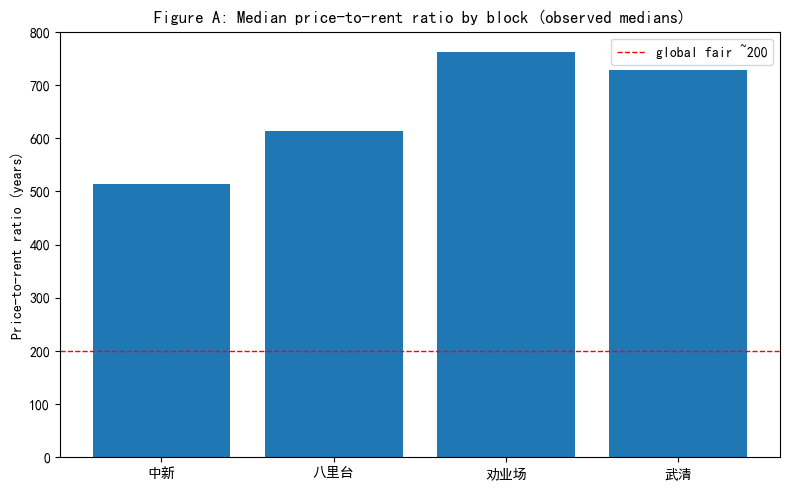

In [12]:
plt.figure(figsize=(8,5))
x = block_stats['location']
y = block_stats['median_price_to_rent_ratio']
plt.bar(x, y)
plt.axhline(200, color='red', linestyle='--', linewidth=1, label='global fair ~200')
plt.ylabel('Price-to-rent ratio (years)')
plt.title('Figure A: Median price-to-rent ratio by block (observed medians)')
plt.legend()
plt.tight_layout()
plt.savefig("Figure_A_median_price_to_rent_observed.png", dpi=150)
plt.show()

## Homework3-4: Model1, Model2

- Model 1 price/m2i = β0m2i + β2locationi + ϵi
- Model 2 rent/m2i = β0m2i + β2locationi + ϵi

In [13]:
import statsmodels.formula.api as smf
# 无截距模型
m1 = smf.ols('price_per_m2 ~ 0 + area + C(location)', data=esf).fit()
m2 = smf.ols('rent_per_m2  ~ 0 + area + C(location)', data=zu).fit()

In [14]:
print("Model1 (no intercept) summary:")
print(m1.summary())


Model1 (no intercept) summary:
                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     3928.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:36:45   Log-Likelihood:                -47246.
No. Observations:                4534   AIC:                         9.450e+04
Df Residuals:                    4529   BIC:                         9.453e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(locatio

In [15]:
print("\nModel2 (no intercept) summary:")
print(m2.summary())


Model2 (no intercept) summary:
                            OLS Regression Results                            
Dep. Variable:            rent_per_m2   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     3849.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:36:45   Log-Likelihood:                -14599.
No. Observations:                3969   AIC:                         2.921e+04
Df Residuals:                    3964   BIC:                         2.924e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(locati

训练集(esf)的 location: {'中新', '武清', '劝业场', '八里台'}
训练集(zu) 的 location: {'中新', '武清', '劝业场', '八里台'}
combined 中的 location: {'中新', '武清', '劝业场', '八里台'}
esf 中有但 combined 没有的 locations: set()
combined 中有但训练集(esf 或 zu) 没有的 locations: set()

每个板块的有效预测数量:
location  n_valid_pred
      中新          2342
     八里台          1658
     劝业场          2188
      武清          2315

Figure B :
location  median_pred_ratio_model12
      中新                     536.51
     八里台                     608.99
     劝业场                     787.23
      武清                     760.35


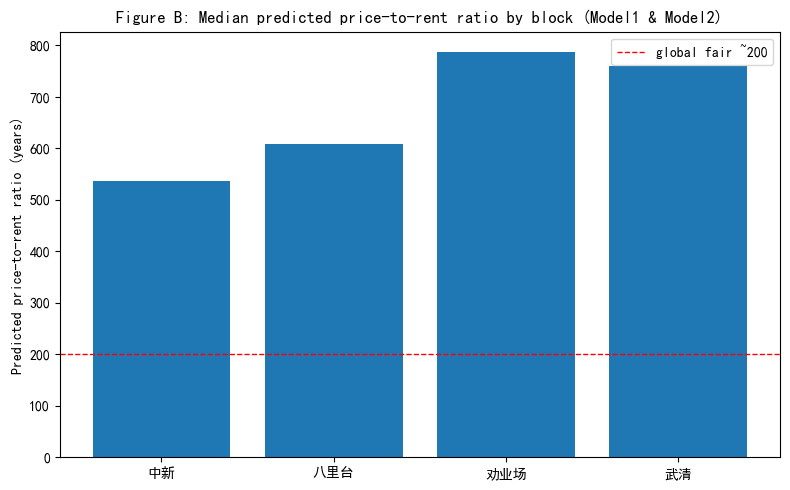

In [16]:
esf_sub = esf[['location','area']].copy()
esf_sub['source'] = 'esf'
zu_sub = zu[['location','area']].copy()
zu_sub['source'] = 'zu'
combined = pd.concat([esf_sub, zu_sub], ignore_index=True)

combined['area'] = pd.to_numeric(combined['area'], errors='coerce')
combined['location'] = combined['location'].astype(str).str.strip()
combined = combined.dropna(subset=['area','location']).reset_index(drop=True)

# 检查训练集与 combined 的 location 
train_locations_esf = set(esf['location'].astype(str).str.strip().unique())
train_locations_zu  = set(zu['location'].astype(str).str.strip().unique())
combined_locations  = set(combined['location'].unique())
print("训练集(esf)的 location:", train_locations_esf)
print("训练集(zu) 的 location:", train_locations_zu)
print("combined 中的 location:", combined_locations)
print("esf 中有但 combined 没有的 locations:", train_locations_esf - combined_locations)
print("combined 中有但训练集(esf 或 zu) 没有的 locations:", combined_locations - (train_locations_esf.union(train_locations_zu)))

# 预测
combined['pred_price_per_m2'] = m1.predict(combined)
combined['pred_rent_per_m2']  = m2.predict(combined)

combined['pred_ratio_model12'] = np.where(
    combined['pred_rent_per_m2'].notna() & (combined['pred_rent_per_m2'] != 0),
    combined['pred_price_per_m2'] / (combined['pred_rent_per_m2'] ),
    np.nan
)

valid_counts = combined.groupby('location').apply(lambda df: df['pred_ratio_model12'].notna().sum()).reset_index().rename(columns={0:'n_valid_pred'})
print("\n每个板块的有效预测数量:")
print(valid_counts.to_string(index=False))

# 按板块取中位数
pred_block = combined.groupby('location', as_index=False)['pred_ratio_model12'].median().rename(columns={'pred_ratio_model12':'median_pred_ratio_model12'})
print("\nFigure B :")
print(pred_block.round(2).to_string(index=False))

#  绘图
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.bar(pred_block['location'], pred_block['median_pred_ratio_model12'])
plt.axhline(200, color='red', linestyle='--', linewidth=1, label='global fair ~200')
plt.ylabel('Predicted price-to-rent ratio (years)')
plt.title('Figure B: Median predicted price-to-rent ratio by block (Model1 & Model2)')
plt.legend()
plt.tight_layout()
plt.savefig("Figure_B_predicted_ratio_model12_fixed.png", dpi=150)
plt.show()


## Homework3-5

In [17]:

extra_features = [] 

combined['area'] = pd.to_numeric(combined['area'], errors='coerce')
esf['area'] = pd.to_numeric(esf['area'], errors='coerce')
zu['area'] = pd.to_numeric(zu['area'], errors='coerce')

esf['area_log'] = np.log(esf['area'])
esf['area_sq'] = esf['area']**2

zu['area_log'] = np.log(zu['area'])
zu['area_sq'] = zu['area']**2

### Model1+(esf)

In [18]:
if 'price_per_m2' in esf.columns and esf['price_per_m2'].notna().sum() > 0:
    # 构造公式字符串
    formula_m1_plus = 'price_per_m2 ~ C(location) + area + I(area**2) + np.log(area)'
    for feat in extra_features:
        if feat in esf.columns:
            formula_m1_plus += ' + ' + feat
    # 添加交互项 location:area
    formula_m1_plus += ' + C(location):area'
    try:
        m1_plus = smf.ols(formula_m1_plus, data=esf).fit()
        print("\nModel1+ formula:", formula_m1_plus)
        print("Model1+ summary :")
        print(m1_plus.summary().tables[1])
    except Exception as e:
        print("拟合 Model1+ 出错：", e)
        m1_plus = None
else:
    m1_plus = None
    print("无法拟合 Model1+")



Model1+ formula: price_per_m2 ~ C(location) + area + I(area**2) + np.log(area) + C(location):area
Model1+ summary :
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2.547e+04   1625.908     15.667      0.000    2.23e+04    2.87e+04
C(location)[T.八里台]       1.002e+04   1002.026      9.995      0.000    8051.154     1.2e+04
C(location)[T.劝业场]        4.13e+04    809.172     51.040      0.000    3.97e+04    4.29e+04
C(location)[T.武清]        -148.9162    944.834     -0.158      0.875   -2001.252    1703.420
area                       57.2865     11.812      4.850      0.000      34.129      80.444
C(location)[T.八里台]:area    56.0178     10.654      5.258      0.000      35.131      76.905
C(location)[T.劝业场]:area   -82.8299      6.372    -12.999      0.000     -95.322     -70.338
C(location)[T.武清]:area     -6.0983      7.572     -0.80

## Model2+（rent）

In [19]:


if 'rent_per_m2' in zu.columns and zu['rent_per_m2'].notna().sum() > 0:
    formula_m2_plus = 'rent_per_m2 ~ C(location) + area + I(area**2) + np.log(area)'
    for feat in extra_features:
        if feat in zu.columns:
            formula_m2_plus += ' + ' + feat
    formula_m2_plus += ' + C(location):area'
    try:
        m2_plus = smf.ols(formula_m2_plus, data=zu).fit()
        print("\nModel2+ formula:", formula_m2_plus)
        print("Model2+ summary :")
        print(m2_plus.summary().tables[1])
    except Exception as e:
        print("拟合 Model2+ 出错：", e)
        m2_plus = None
else:
    m2_plus = None
    print("无法拟合 Model2+")



Model2+ formula: rent_per_m2 ~ C(location) + area + I(area**2) + np.log(area) + C(location):area
Model2+ summary :
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  84.4663      4.160     20.304      0.000      76.310      92.622
C(location)[T.八里台]         13.0054      1.287     10.104      0.000      10.482      15.529
C(location)[T.劝业场]         26.0503      1.270     20.516      0.000      23.561      28.540
C(location)[T.武清]          -9.1850      1.338     -6.865      0.000     -11.808      -6.562
area                        0.1056      0.024      4.351      0.000       0.058       0.153
C(location)[T.八里台]:area     0.0223      0.012      1.786      0.074      -0.002       0.047
C(location)[T.劝业场]:area     0.0835      0.012      6.777      0.000       0.059       0.108
C(location)[T.武清]:area      0.0005      0.013      0.037

In [20]:
# 比较 R^2和调整后的 R^2
def r2_info(name, model):
    if model is None:
        return f"{name}: no model"
    return f"{name}: R2={model.rsquared:.4f}, Adj R2={model.rsquared_adj:.4f}, nobs={int(model.nobs)}"

print("\n===== R2 比较 =====")
print(r2_info('Model1', m1))
print(r2_info('Model1+', m1_plus))
print(r2_info('Model2', m2))
print(r2_info('Model2+', m2_plus))


===== R2 比较 =====
Model1: R2=0.7762, Adj R2=0.7760, nobs=4534
Model1+: R2=0.7990, Adj R2=0.7986, nobs=4534
Model2: R2=0.7952, Adj R2=0.7950, nobs=3969
Model2+: R2=0.8141, Adj R2=0.8137, nobs=3969


使用 Model1+ 和 Model2+ 对 combined 进行预测

In [21]:
combined['pred_price_per_m2_model1plus'] = np.nan
combined['pred_rent_per_m2_model2plus'] = np.nan
predict_env = {'np': np}

if m1_plus is not None:   
    combined['pred_price_per_m2_model1plus'] = m1_plus.predict(combined)
elif m1 is not None:
    combined['pred_price_per_m2_model1plus'] = m1.predict(combined)

if m2_plus is not None:
    combined['pred_rent_per_m2_model2plus'] = m2_plus.predict(combined)
elif m2 is not None:
    combined['pred_rent_per_m2_model2plus'] = m2.predict(combined)

combined['pred_ratio_model1plus2plus'] = combined['pred_price_per_m2_model1plus'] / (combined['pred_rent_per_m2_model2plus'] )

Figure C


===== Figure C 数据（Model1+ & Model2+ 预测得到的每块中位 ratio） =====
location  median_pred_ratio_model1plus2plus
      中新                             504.13
     八里台                             596.38
     劝业场                             802.71
      武清                             741.05


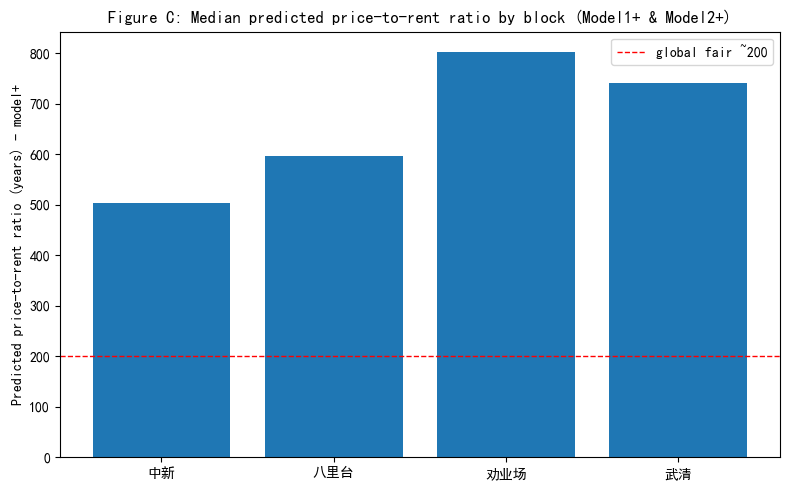

In [22]:
pred_block_c = combined.groupby('location')['pred_ratio_model1plus2plus'].median().reset_index().rename(columns={'pred_ratio_model1plus2plus':'median_pred_ratio_model1plus2plus'})
print("\n===== Figure C 数据（Model1+ & Model2+ 预测得到的每块中位 ratio） =====")
print(pred_block_c.round(2).to_string(index=False))

plt.figure(figsize=(8,5))
plt.bar(pred_block_c['location'], pred_block_c['median_pred_ratio_model1plus2plus'])
plt.axhline(200, color='red', linestyle='--', linewidth=1, label='global fair ~200')
plt.ylabel('Predicted price-to-rent ratio (years) - model+')
plt.title('Figure C: Median predicted price-to-rent ratio by block (Model1+ & Model2+)')
plt.legend()
plt.tight_layout()
plt.savefig("Figure_C_predicted_ratio_model1plus2plus.png", dpi=150)
plt.show()

In [23]:
compare_df = pd.merge(block_stats[['location','median_price_per_m2','median_rent_per_m2','median_price_to_rent_ratio']],
                      pred_block.rename(columns={'median_pred_ratio_model12':'median_ratio_model12'}),
                      on='location', how='outer')
compare_df = pd.merge(compare_df, pred_block_c.rename(columns={'median_pred_ratio_model1plus2plus':'median_ratio_model1plus2plus'}),
                      on='location', how='outer')

esf_counts = esf.groupby('location').size().rename('n_esf').reset_index()
zu_counts = zu.groupby('location').size().rename('n_zu').reset_index()
compare_df = compare_df.merge(esf_counts, on='location', how='left').merge(zu_counts, on='location', how='left')
compare_df = compare_df.fillna('NA')
print("\n===== 三种方法对比（每块） =====")
print(compare_df.round(2).to_string(index=False))

# 保存比对表
compare_df.to_csv("block_price_rent_ratio_comparison.csv", index=False)


===== 三种方法对比（每块） =====
location  median_price_per_m2  median_rent_per_m2  median_price_to_rent_ratio  median_ratio_model12  median_ratio_model1plus2plus  n_esf  n_zu
      中新              12698.0               24.71                      513.97                536.51                        504.13   1193  1149
     八里台              25324.0               41.31                      612.95                608.99                        596.38   1086   572
     劝业场              46905.0               61.54                      762.21                787.23                        802.71   1118  1070
      武清              11432.0               15.68                      729.07                760.35                        741.05   1137  1178


计算VIF检查多重共线性，稳健标准误HC3，Breusch-Pagan 异方差检验以及残差诊断图

In [24]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import seaborn as sns
from IPython.display import display, Markdown


plt.rcParams.update({'figure.max_open_warning': 0, 'figure.dpi': 120})

 模型：`m1`

VIF（按降序）

,variable,VIF
0,C(location)[中新],2.835442
1,C(location)[武清],2.483217
2,C(location)[劝业场],1.485885
3,area,1.377083
4,C(location)[八里台],1.370369


**OLS summary（原始）**

                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     3928.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:36:47   Log-Likelihood:                -47246.
No. Observations:                4534   AIC:                         9.450e+04
Df Residuals:                    4529   BIC:                         9.453e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(location)[中新]   1.507e+04    395.851  

**OLS summary（HC3 稳健标准误）**

                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 16 Oct 2025   Prob (F-statistic):                nan
Time:                        14:36:47   Log-Likelihood:                -47246.
No. Observations:                4534   AIC:                         9.450e+04
Df Residuals:                    4529   BIC:                         9.453e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(location)[中新]   1.507e+04    385.372  

**Breusch–Pagan 检验出错：** `The Breusch-Pagan test requires exog to have at least two columns where one is a constant.`

诊断图已保存为：`m1_diagnostics.png`

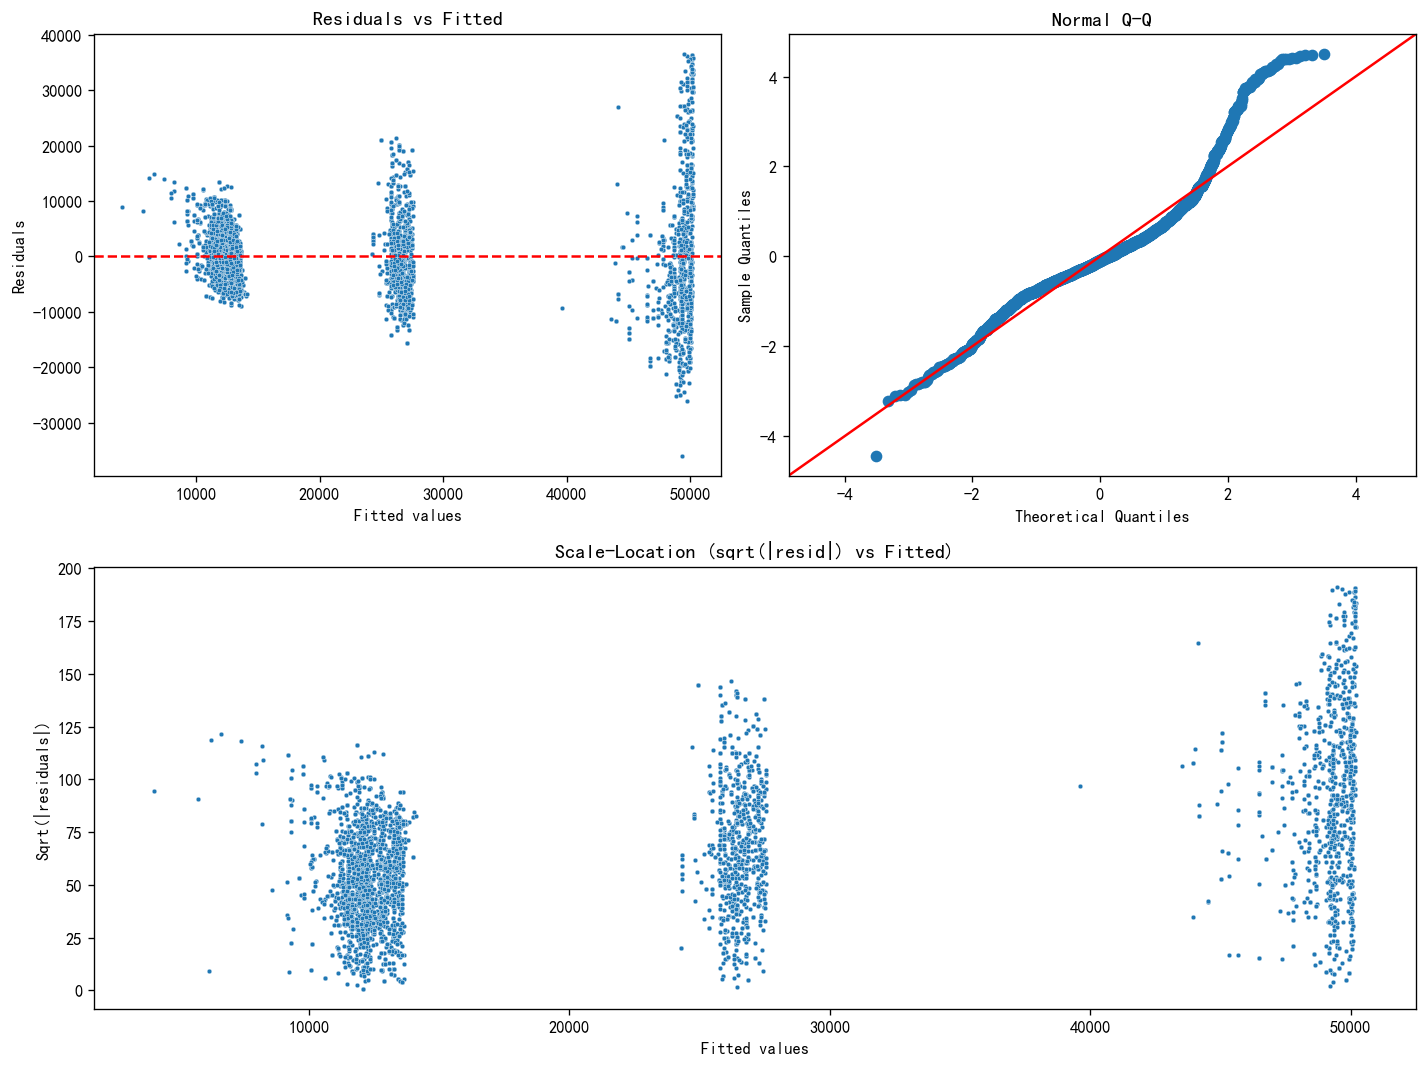

---

 模型：`m1_plus`

VIF（按降序）

,variable,VIF
0,Intercept,202.147540
1,area,31.919620
2,C(location)[T.八里台],13.985205
3,C(location)[T.武清],12.825678
4,C(location)[T.武清]:area,12.253495
5,I(area ** 2),12.108696
6,np.log(area),9.392471
7,C(location)[T.劝业场],9.301549
8,C(location)[T.八里台]:area,7.735361
9,C(location)[T.劝业场]:area,5.386435


**OLS summary（原始）**

                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     1998.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:36:49   Log-Likelihood:                -47003.
No. Observations:                4534   AIC:                         9.403e+04
Df Residuals:                    4524   BIC:                         9.409e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2

**OLS summary（HC3 稳健标准误）**

                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     1476.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:36:49   Log-Likelihood:                -47003.
No. Observations:                4534   AIC:                         9.403e+04
Df Residuals:                    4524   BIC:                         9.409e+04
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2

**Breusch–Pagan 异方差检验**

LM stat = 1100.9764, LM p-value = 2.8559e-231
F-stat = 161.2060, F p-value = 1.8489e-265
结论：拒绝同方差零假设（存在异方差），建议使用稳健标准误或方差建模（WLS）。


诊断图已保存为：`m1_plus_diagnostics.png`

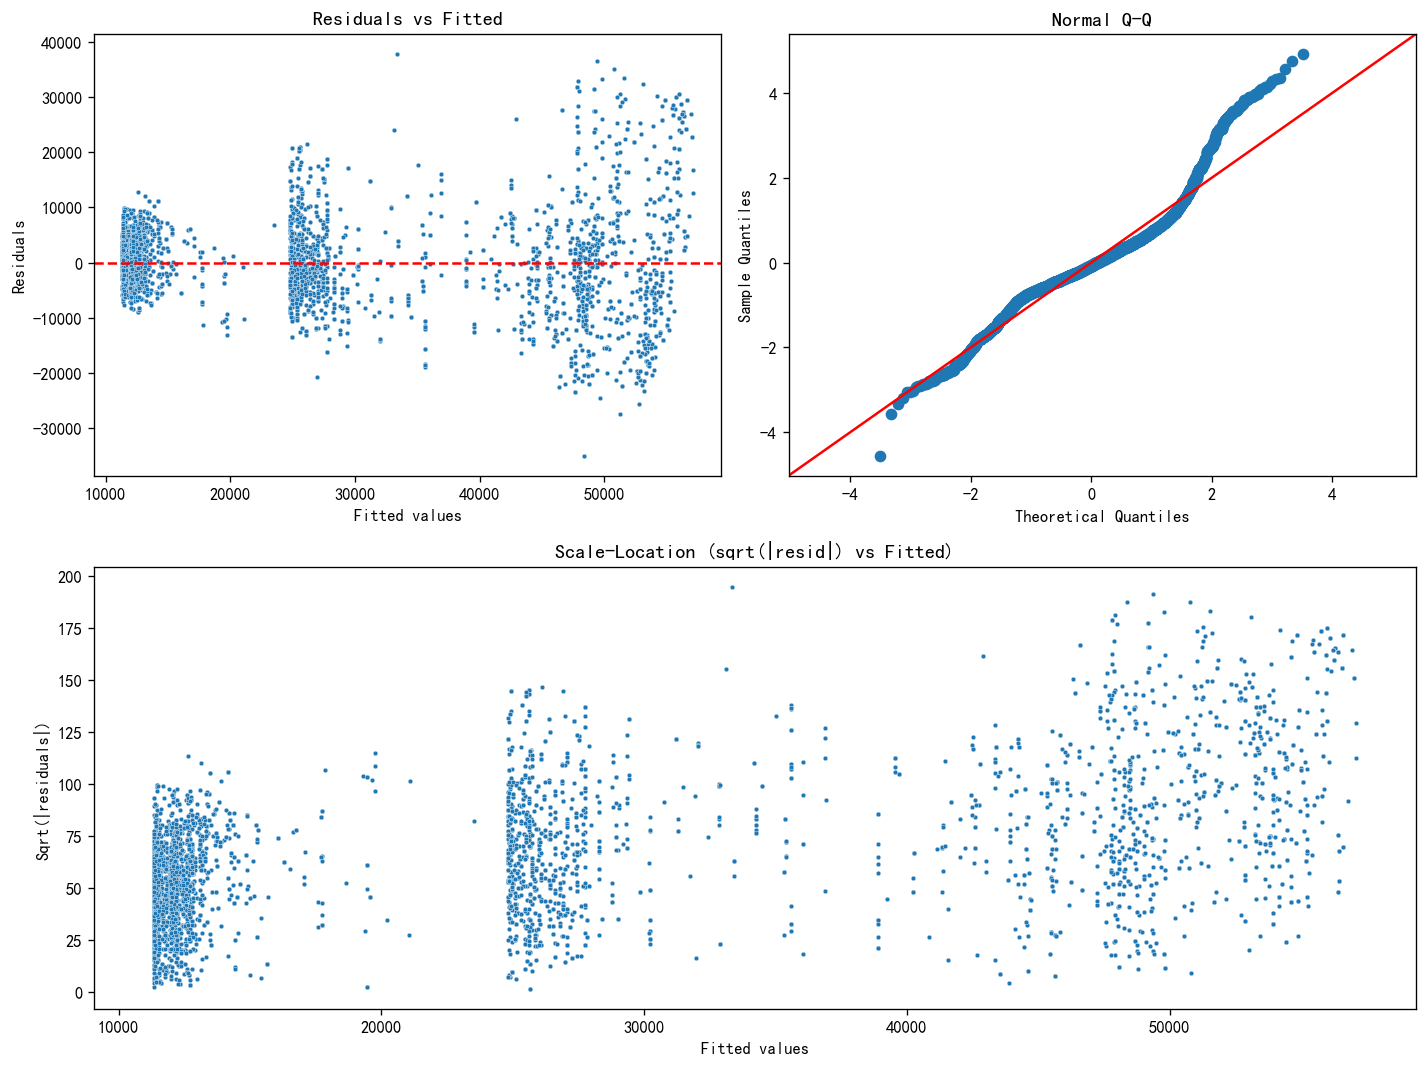

---

 模型：`m2`

VIF（按降序）

,variable,VIF
0,C(location)[武清],2.495525
1,C(location)[中新],2.422340
2,C(location)[劝业场],1.538604
3,C(location)[八里台],1.479896
4,area,1.126218


**OLS summary（原始）**

                            OLS Regression Results                            
Dep. Variable:            rent_per_m2   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     3849.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:36:50   Log-Likelihood:                -14599.
No. Observations:                3969   AIC:                         2.921e+04
Df Residuals:                    3964   BIC:                         2.924e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(location)[中新]     26.1064      0.440  

**OLS summary（HC3 稳健标准误）**

                            OLS Regression Results                            
Dep. Variable:            rent_per_m2   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 16 Oct 2025   Prob (F-statistic):                nan
Time:                        14:36:50   Log-Likelihood:                -14599.
No. Observations:                3969   AIC:                         2.921e+04
Df Residuals:                    3964   BIC:                         2.924e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(location)[中新]     26.1064      0.561  

**Breusch–Pagan 检验出错：** `The Breusch-Pagan test requires exog to have at least two columns where one is a constant.`

诊断图已保存为：`m2_diagnostics.png`

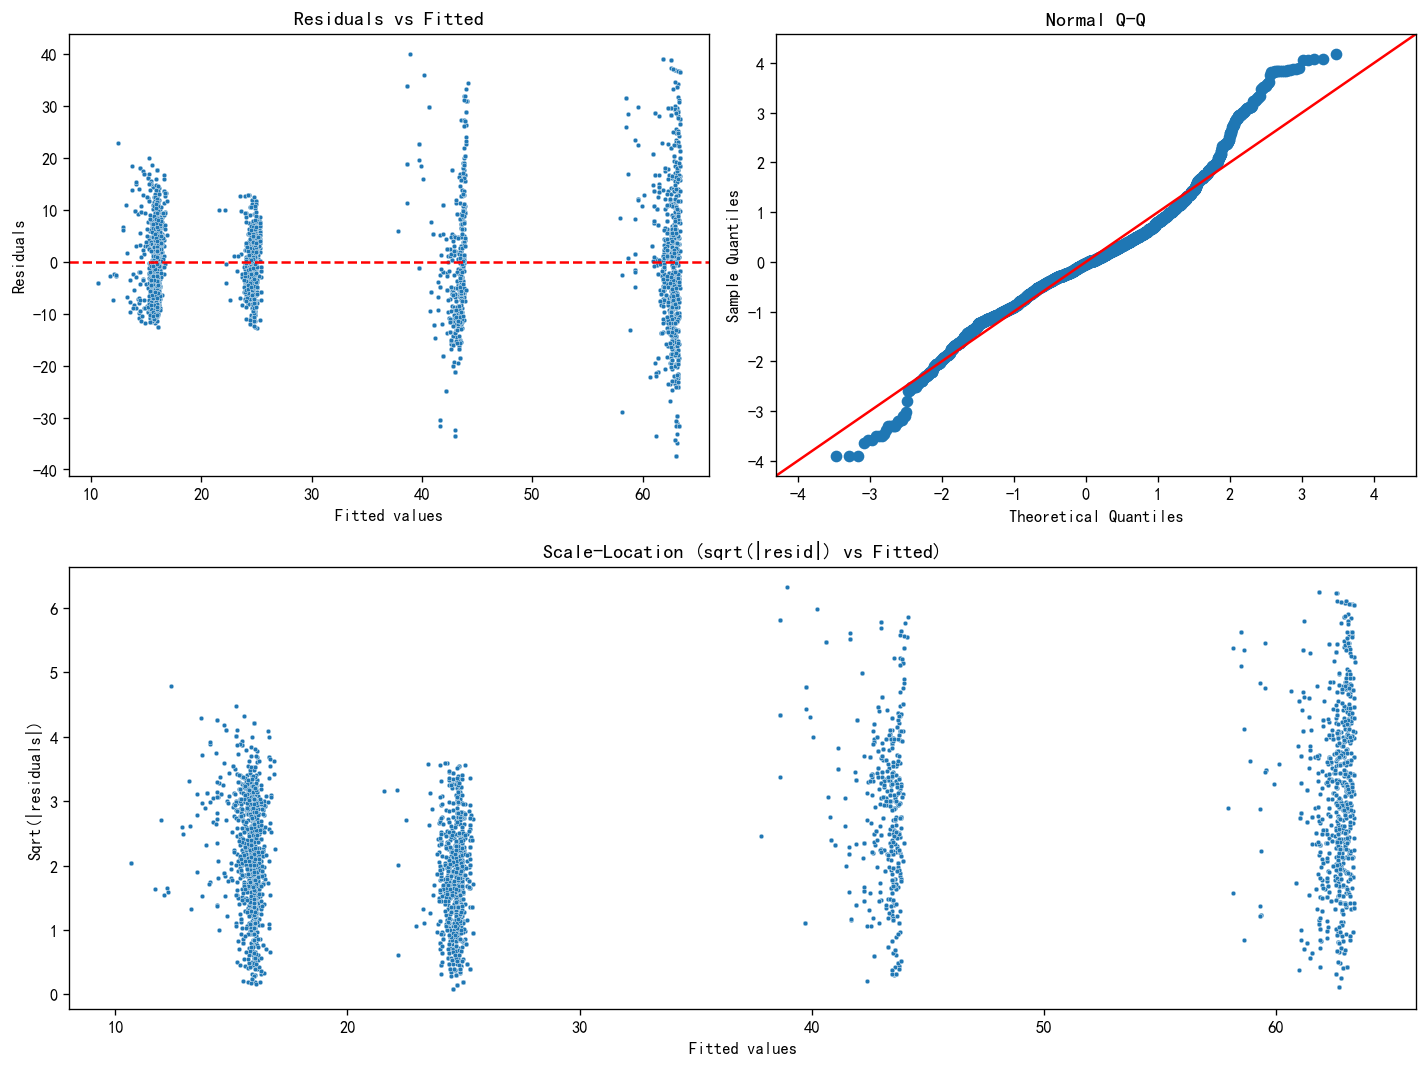

---

 模型：`m2_plus`

VIF（按降序）

,variable,VIF
0,Intercept,822.912044
1,area,66.125250
2,I(area ** 2),26.106902
3,np.log(area),22.207425
4,C(location)[T.武清]:area,20.605124
5,C(location)[T.武清],17.764722
6,C(location)[T.劝业场],15.095513
7,C(location)[T.劝业场]:area,11.530059
8,C(location)[T.八里台]:area,11.035387
9,C(location)[T.八里台],9.718079


**OLS summary（原始）**

                            OLS Regression Results                            
Dep. Variable:            rent_per_m2   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     1927.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:36:51   Log-Likelihood:                -14407.
No. Observations:                3969   AIC:                         2.883e+04
Df Residuals:                    3959   BIC:                         2.890e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

**OLS summary（HC3 稳健标准误）**

                            OLS Regression Results                            
Dep. Variable:            rent_per_m2   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     1411.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:36:51   Log-Likelihood:                -14407.
No. Observations:                3969   AIC:                         2.883e+04
Df Residuals:                    3959   BIC:                         2.890e+04
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

**Breusch–Pagan 异方差检验**

LM stat = 629.2426, LM p-value = 1.1045e-129
F-stat = 82.8793, F p-value = 1.9189e-141
结论：拒绝同方差零假设（存在异方差），建议使用稳健标准误或方差建模（WLS）。


诊断图已保存为：`m2_plus_diagnostics.png`

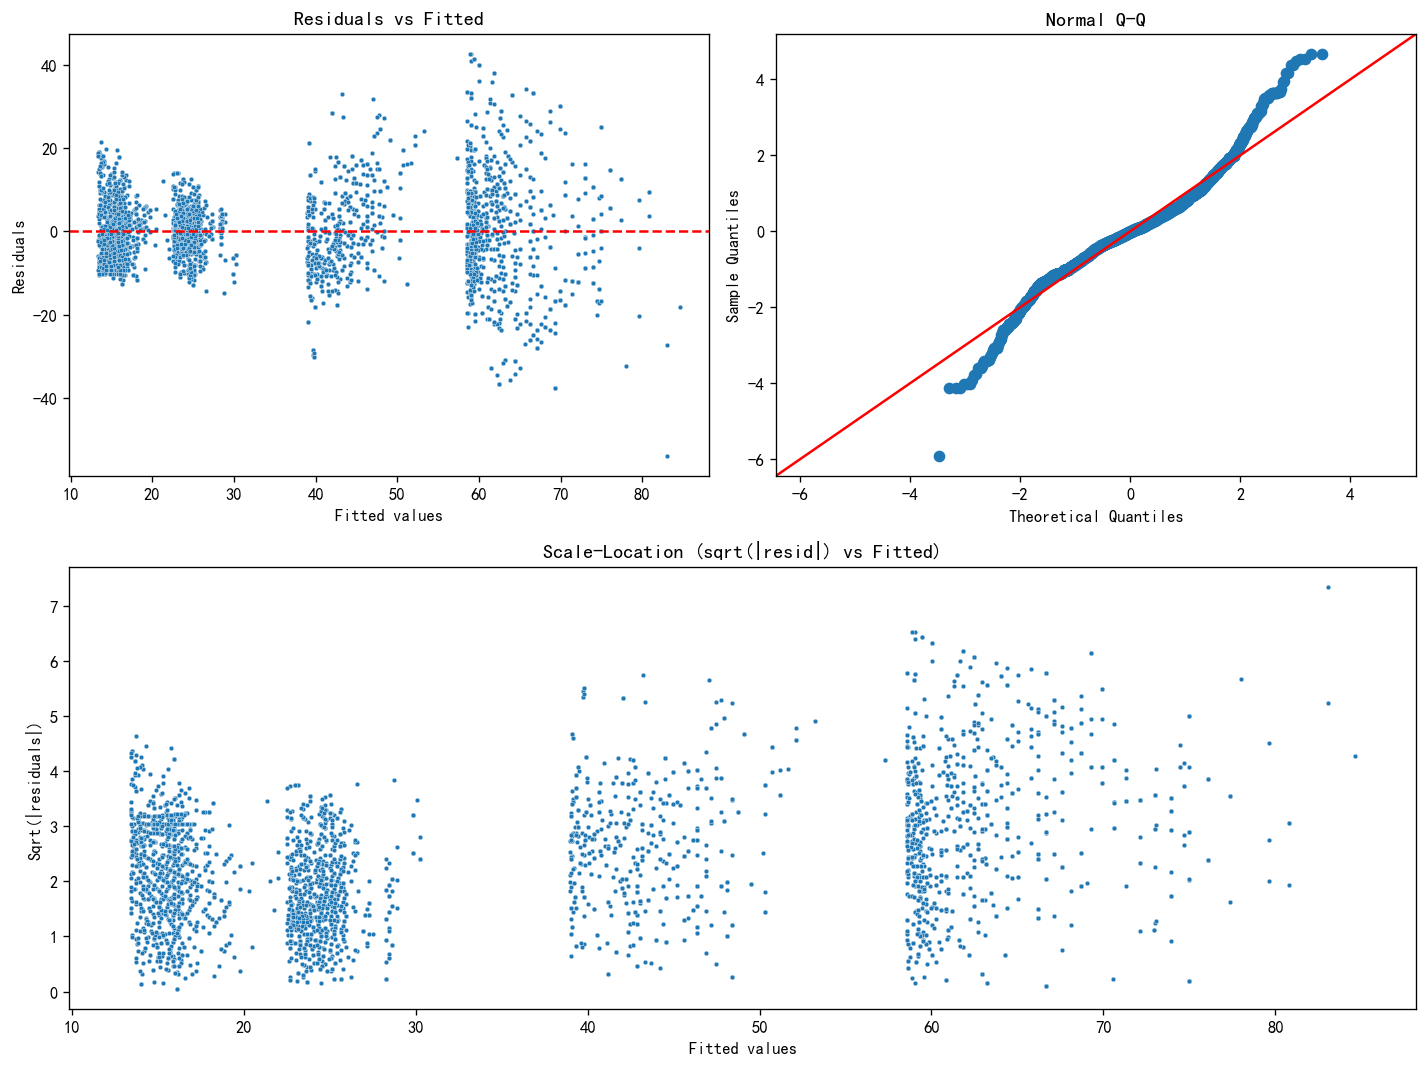

---

In [25]:
model_names = ['m1', 'm1_plus', 'm2', 'm2_plus']   # 要检查的模型变量名列表
save_plots = True 
plot_folder_prefix = ""  

for name in model_names:
    display(Markdown(f" 模型：`{name}`"))
    if name not in globals() or globals()[name] is None:
        display(Markdown(f"跳过：变量 `{name}` 未定义或为 None。请先拟合该模型后再运行。"))
        continue
    model = globals()[name]

    # VIF
    try:
        X = model.model.exog
        var_names = model.model.exog_names
        vif_list = []
        for i in range(X.shape[1]):
            try:
                vif_val = variance_inflation_factor(X, i)
            except Exception:
                vif_val = np.nan
            vif_list.append(vif_val)
        vif_df = pd.DataFrame({'variable': var_names, 'VIF': vif_list}).sort_values('VIF', ascending=False).reset_index(drop=True)
        display(Markdown("VIF（按降序）"))
        display(vif_df)
    except Exception as e:
        display(Markdown(f"计算 VIF 出错： `{e}`"))
    
       # HC3 稳健标准误回归表
    try:
        robust = model.get_robustcov_results(cov_type='HC3')
        display(Markdown("**OLS summary（原始）**"))
        print(model.summary())
        display(Markdown("**OLS summary（HC3 稳健标准误）**"))
        print(robust.summary())
    except Exception as e:
        display(Markdown(f"**输出 HC3 结果出错：** `{e}`"))

    # Breusch-Pagan 异方差检验
    try:
        resid = model.resid
        exog = model.model.exog
        lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(resid, exog)
        display(Markdown("**Breusch–Pagan 异方差检验**"))
        print(f"LM stat = {lm:.4f}, LM p-value = {lm_pvalue:.4e}")
        print(f"F-stat = {fvalue:.4f}, F p-value = {f_pvalue:.4e}")
        if lm_pvalue < 0.05:
            print("结论：拒绝同方差零假设（存在异方差），建议使用稳健标准误或方差建模（WLS）。")
        else:
            print("结论：不能拒绝同方差零假设（未发现显著异方差）。")
    except Exception as e:
        display(Markdown(f"**Breusch–Pagan 检验出错：** `{e}`"))

    # 残差诊断图：Residuals vs Fitted / QQ / Scale-Location
    try:
        resid = model.resid
        fitted = model.fittedvalues
        fig = plt.figure(figsize=(12,9))
        gs = fig.add_gridspec(2,2)
        ax0 = fig.add_subplot(gs[0,0])
        ax1 = fig.add_subplot(gs[0,1])
        ax2 = fig.add_subplot(gs[1,:])

        # Residuals vs Fitted
        sns.scatterplot(x=fitted, y=resid, ax=ax0, s=8)
        ax0.axhline(0, color='red', linestyle='--')
        ax0.set_xlabel('Fitted values')
        ax0.set_ylabel('Residuals')
        ax0.set_title('Residuals vs Fitted')

        # QQ plot
        sm.qqplot(resid, line='45', ax=ax1, fit=True)
        ax1.set_title('Normal Q-Q')

        # Scale-Location
        sns.scatterplot(x=fitted, y=np.sqrt(np.abs(resid)), ax=ax2, s=8)
        ax2.set_xlabel('Fitted values')
        ax2.set_ylabel('Sqrt(|residuals|)')
        ax2.set_title('Scale-Location (sqrt(|resid|) vs Fitted)')

        plt.tight_layout()
        if save_plots:
            fname = f"{plot_folder_prefix}{name}_diagnostics.png"
            plt.savefig(fname, dpi=150, bbox_inches='tight')
            display(Markdown(f"诊断图已保存为：`{fname}`"))
        plt.show()
        plt.close(fig)
    except Exception as e:
        display(Markdown(f"**绘制残差图出错：** `{e}`"))

    display(Markdown("---"))  # 分隔线


**一、总体拟合（R² / 样本量）**  
- **Model1（price, no intercept）**：R² = **0.7762**, Adj R² = **0.7760**, n = **4534**。  
- **Model1+（price, 加入 area²、log(area)、交互）**：R² = **0.7990**, Adj R² = **0.7986**, n = **4534**（较 Model1 提升 ∼2.8 个百分点）。  
- **Model2（rent, no intercept）**：R² = **0.7952**, Adj R² = **0.7950**, n = **3969**。  
- **Model2+（rent 增强版）**：R² = **0.8141**, Adj R² = **0.8137**, n = **3969**（较 Model2 提升 ∼1.9 个百分点）。  


**二、关键系数（要点，基于最新估计值）**  
- **Model1 (no intercept)**  
  - 地点截面效应（基准形式给出各片区平均单价）：中新 ≈ **15070 元/㎡**，八里台 ≈ **27560 元/㎡**，劝业场 ≈ **50380 元/㎡**，武清 ≈ **13810 元/㎡**；  
  - `area` 系数 ≈ **−18.12**（显著），单一线性模型下仍表现“面积越大单价略下降”的平均效应。  
- **Model2 (no intercept)**  
  - 租金单价：中新 ≈ **26.11 元/㎡·月**，八里台 ≈ **44.33**，劝业场 ≈ **63.54**，武清 ≈ **17.24**；  
  - `area` ≈ **−0.0143**（显著但幅度很小）。  
- **Model1+（增强，含交互与非线性）**  
  - 截距 ≈ **25470**；八里台的地点主效应 ≈ **10020**，劝业场 ≈ **41300**，武清不显著（≈ −149，p>0.2）；  
  - `area` ≈ **+57.29**（显著），但同时 `np.log(area)` ≈ **−4115.64**（显著，绝对值较大），`I(area**2)` 非显著；  
  - 交互：八里台:area ≈ **+56.02**（显著），劝业场:area ≈ **−82.83**（显著），武清:area 不显著。  
  - 说明：面积对单价的影响在增强模型中呈**强烈非线性并且分片区异质**，小户型/中户型/大户型在不同片区的边际单价差别较大。  
- **Model2+（租金增强版）**  
  - 截距 ≈ **84.47**；八里台主效应 ≈ **13.01**，劝业场 ≈ **26.05**，武清 ≈ **−9.19**（显著）；  
  - `area` ≈ **+0.1056**（显著），`np.log(area)` ≈ **−15.22**（显著），`I(area**2)` 非显著；  
  - 交互：劝业场:area ≈ **+0.0835**（显著），八里台:area 较弱边际（p≈0.074），武清:area 不显著。  
  - 说明：租金也存在非线性与分区差异，但弹性与数值量级小于价格模型。


**三、结论**  
删除异常值后，模型拟合力明显提升；增强模型（Model1+ / Model2+）仍优于简单模型，能更好捕捉面积的非线性与片区异质性。